## 1ο Ερώτημα - Φόρτωση Δεδομένων στο colab ή local

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/datasets/dermoscopy_classification.tar.gz' .
!tar -xvzf dermoscopy_classification.tar.gz
data_dir = '/content/dermoscopy_classification'

Local Load:

In [1]:
data_dir = 'dermoscopy_classification'

Imports:

In [2]:
import os
import glob
import random
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms, models
from torchvision.io import read_image
from torch.utils.data import Dataset, Subset
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torch.utils.data import random_split
from torchsummary import summary

## 2ο Ερώτημα - Φόρτωση Δεδομένων:

In [3]:
class MLProject2Dataset(Dataset):

    def __init__(self, data_dir: str, metadata_fname: str ='metadata.csv', transform: transforms = None) -> None:
        super().__init__()
        if data_dir[-1] != '/':
            data_dir += '/'

        self.data_dir = data_dir
        self.transform = transform

        imgdf = pd.DataFrame(columns=['image_id', 'path'])

        all_img_paths = glob.glob(f'{self.data_dir}**/*.jpg', recursive=True)

        for path in all_img_paths:
            image_id = os.path.basename(path).split('.')[0]
            imgdf = imgdf._append({'image_id': image_id, 'path': path}, ignore_index=True)

        metadf = pd.read_csv(self.data_dir + metadata_fname)
        metadf['dx'] = pd.Categorical(metadf['dx']).codes

        self.df = pd.merge(imgdf, metadf, on='image_id')
        # print(self.df.iloc[:, 3]) # dx
        # Used in lesion_id:
        self.df = self.df.sort_values(by='lesion_id', ascending=True)
        self.df = self.df.reset_index(drop=True)


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx, 1] # paths
        img = read_image(path)
        img = img.to(torch.float32) / 255

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(self.df.iloc[idx, 3], dtype=torch.int64)

In [4]:
def split_lesion(dataset: MLProject2Dataset, train_size: float, valid_size: float, test_size: float):
   """ Used to split datasets according to lesion_id. """
   # Used for debugging:
   # train = dataset.df[:train_size]
   # valid = dataset.df[train_size:train_size+valid_size]
   # test = dataset.df[train_size+valid_size:train_size+valid_size+test_size]
   # print(train.tail(1))
   # print(valid.head(1))
   # print(valid.tail(1))
   # print(test.head(1))

   train_indices = list(range(int(train_size)))
   valid_indices = list(range(int(train_size), int(train_size + valid_size)))
   test_indices = list(range(int(train_size + valid_size), int(train_size + valid_size + test_size)))

   random.shuffle(train_indices)
   random.shuffle(valid_indices)
   random.shuffle(test_indices)

   return [Subset(dataset, train_indices), Subset(dataset, valid_indices), Subset(dataset, test_indices)]


2.3 , 2.4 - Testing the dataset class:

In [5]:
m, n = 64, 64

transform = transforms.Compose([
   transforms.Resize((m, n), antialias=True),
   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = MLProject2Dataset(data_dir, transform=transform)

print(len(dataset))
print(dataset[2])

torch.manual_seed(42)

train_size = int(0.6 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

10015
(tensor([[[0.4664, 0.4891, 0.5250,  ..., 0.5190, 0.4905, 0.4622],
         [0.4868, 0.4953, 0.5292,  ..., 0.5345, 0.5000, 0.4744],
         [0.4961, 0.5070, 0.5298,  ..., 0.5402, 0.5143, 0.4871],
         ...,
         [0.5269, 0.5537, 0.5692,  ..., 0.5671, 0.5499, 0.5412],
         [0.5209, 0.5437, 0.5578,  ..., 0.5695, 0.5422, 0.5210],
         [0.5049, 0.5214, 0.5499,  ..., 0.5607, 0.5388, 0.5141]],

        [[0.1828, 0.2252, 0.2727,  ..., 0.2110, 0.1336, 0.1097],
         [0.2044, 0.1881, 0.2477,  ..., 0.2309, 0.1466, 0.1122],
         [0.1964, 0.1719, 0.2085,  ..., 0.2402, 0.1834, 0.1500],
         ...,
         [0.2109, 0.2103, 0.2088,  ..., 0.2808, 0.2226, 0.1895],
         [0.2149, 0.2421, 0.2080,  ..., 0.2883, 0.2378, 0.1801],
         [0.1987, 0.2181, 0.2269,  ..., 0.2731, 0.2549, 0.2140]],

        [[0.1787, 0.2104, 0.2548,  ..., 0.2324, 0.1824, 0.1720],
         [0.1998, 0.1698, 0.2286,  ..., 0.2471, 0.1983, 0.1862],
         [0.2035, 0.1681, 0.1994,  ..., 0.2579, 0.2

## 3ο Ερώτημα - Μέθοδοι Εκπαίδευσης και Δοκιμής

In [6]:
def train_net(model: nn.Module, trainloader: DataLoader, valloader: DataLoader = None, epochs: int = 10, optimizer: optim = None, loss: nn.modules.loss = None, device: str = 'cpu', print_period: int = 10) -> None:
    model.train()
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for batch, (X, y) in enumerate(trainloader, 0):
            X = X.to(device)
            # print(y)
            y = y.to(device)
            optimizer.zero_grad()
            pred = model(X)
            current_loss = loss(pred, y)
            current_loss.backward()
            optimizer.step()
            running_loss += current_loss.item()

            yhat = torch.argmax(pred, 1)
            total += y.size(0)
            correct += (yhat == y).type(torch.float).sum().item()   # counts accuracy.

            if batch % print_period == print_period-1:
                avg_loss = running_loss / print_period
                avg_acc = correct / total
                train_acc.append(avg_acc)
                train_loss.append(avg_loss)
                print(f'[Epoch: {epoch}, batch: {batch:5d}] Average train loss: {avg_loss:.3f} | accuracy: {avg_acc:.3f}')
                running_loss = 0.0
                correct = 0
                total = 0

                if valloader is not None:
                    model.eval()  # evaluation mode
                    running_val_loss = 0.0
                    correct_val = 0
                    total_val = 0
                    with torch.no_grad():
                        for batch, (X, y) in enumerate(valloader, 0):
                            X, y = X.to(device), y.to(device)
                            pred = model(X)
                            current_loss = loss(pred, y)
                            running_val_loss += current_loss.item()

                            yhat = torch.argmax(pred, 1)
                            total_val += y.size(0)
                            correct_val += (yhat == y).type(torch.float).sum().item()   # counts accuracy.
                        avg_loss = running_val_loss / len(valloader)
                        avg_acc = correct_val / total_val
                        val_loss.append(avg_loss)
                        val_acc.append(avg_acc)
                        print(f'Average val loss: {avg_loss:.3f} | accuracy: {avg_acc:.3f}')
                    model.train()  # training mode
    plot_acc_loss(train_acc, train_loss, title="Trainning Results")
    if len(val_loss) != 0 and len(val_acc) != 0:
        plot_acc_loss(val_acc, val_loss, title="Validation Results")
        plot_acc_loss(train_acc, val_acc, label1="Train Acc", label2="Valid Acc", y_label="Average Accuracy", title="Trainning VS Validation Accuracy")
        plot_acc_loss(train_loss, val_loss, label1="Train Loss", label2="Valid Loss", y_label="Average Loss", title="Trainning VS Validation Loss")


def test_net(model: nn.Module, testloader: DataLoader, loss: nn.modules.loss = None, device: str = 'cpu') -> None:
    model.eval()
    total = 0
    correct = 0
    running_loss = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for (X, y) in testloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            current_loss = loss(pred, y)
            running_loss += current_loss.item()
            yhat = torch.argmax(pred, 1)
            total += y.size(0)
            correct += (yhat == y).type(torch.float).sum().item()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(yhat.cpu().numpy())
    avg_loss = running_loss / len(testloader)
    avg_acc = correct / total
    print("===============")
    print(f"Average test loss: {avg_loss:.3f} | accuracy: {avg_acc:.3f}")
    print("Confusion Matrix: ")
    print(confusion_matrix(y_true, y_pred))
    print("===============")


def plot_acc_loss(list1: list, list2: list, label1="Accuracy", label2="Loss", x_label=None, y_label='Avg Accuracy & Loss', title=None):
    x_values1 = list(range(len(list1)))
    x_values2 = list(range(len(list2)))

    plt.figure(figsize=(8, 6))
    plt.plot(x_values1, list1, marker='o', linestyle='-', color='b', label=label1)
    plt.plot(x_values2, list2, marker='x', linestyle='--', color='r', label=label2)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 4ο Ερώτημα - Απλό ΣΝΔ

In [7]:
class SimpleModel(nn.Module):
    """Simple convolutional neural network"""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, (3, 3))
        self.conv2 = nn.Conv2d(32, 64, (3, 3))
        self.conv3 = nn.Conv2d(64, 64, (3, 3))
        self.pool = nn.MaxPool2d((2, 2))
        self.fc = nn.Linear(1536, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        # used to get the input parameter in linear.
        # print(x.shape)
        x = self.fc(x)
        return x


[Epoch: 0, batch:     9] Average train loss: 1.244 | accuracy: 0.630
Average val loss: 1.214 | accuracy: 0.674
[Epoch: 0, batch:    19] Average train loss: 1.163 | accuracy: 0.661
Average val loss: 1.326 | accuracy: 0.673
[Epoch: 0, batch:    29] Average train loss: 1.082 | accuracy: 0.672
Average val loss: 1.205 | accuracy: 0.674
[Epoch: 0, batch:    39] Average train loss: 1.086 | accuracy: 0.661
Average val loss: 1.019 | accuracy: 0.674
[Epoch: 0, batch:    49] Average train loss: 1.087 | accuracy: 0.630
Average val loss: 0.996 | accuracy: 0.675
[Epoch: 0, batch:    59] Average train loss: 0.997 | accuracy: 0.691
Average val loss: 1.027 | accuracy: 0.674
[Epoch: 0, batch:    69] Average train loss: 1.030 | accuracy: 0.636
Average val loss: 0.954 | accuracy: 0.676
[Epoch: 0, batch:    79] Average train loss: 0.933 | accuracy: 0.691
Average val loss: 0.961 | accuracy: 0.676
[Epoch: 0, batch:    89] Average train loss: 1.013 | accuracy: 0.675
Average val loss: 0.952 | accuracy: 0.675
[

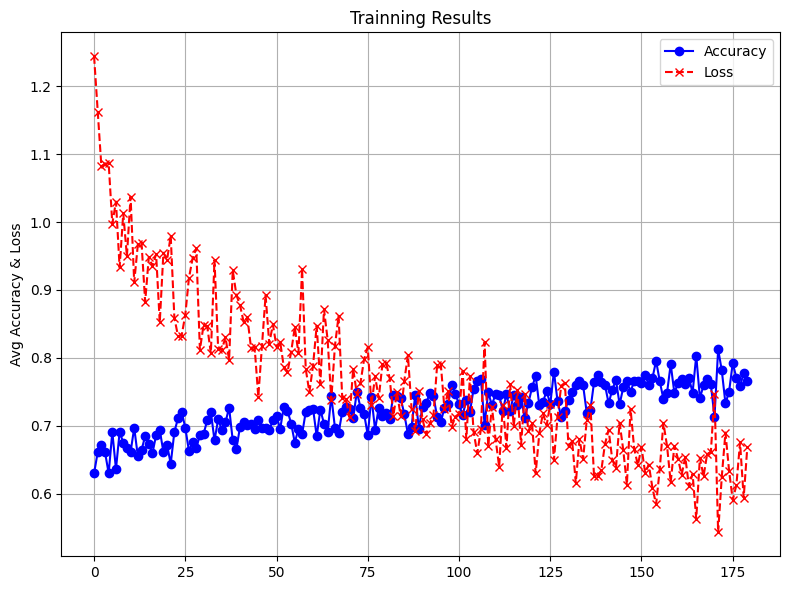

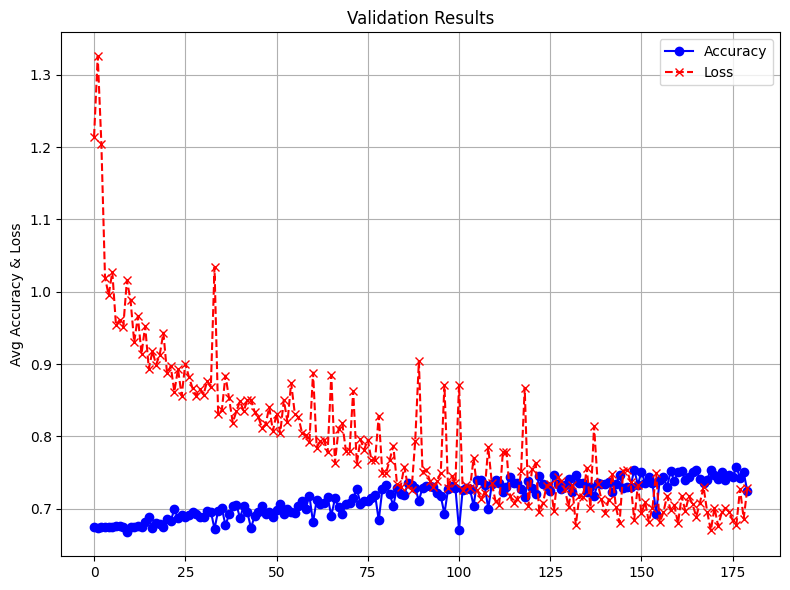

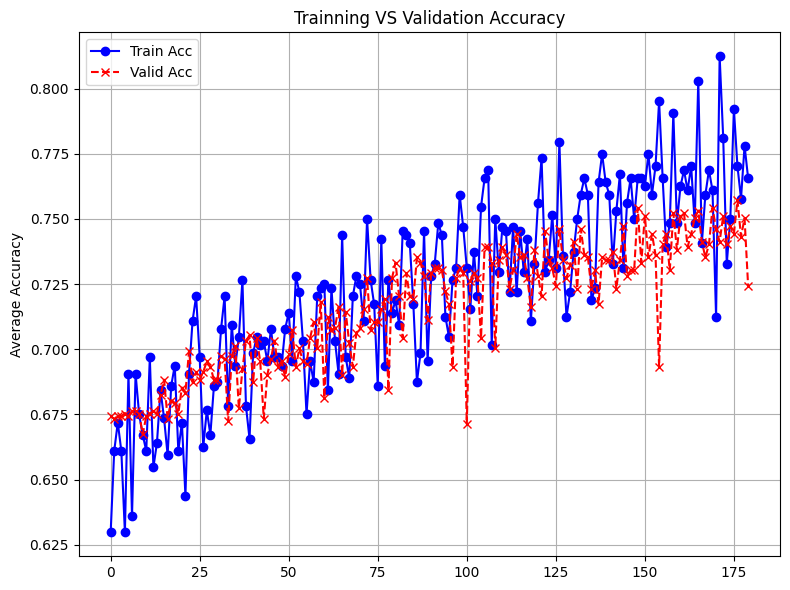

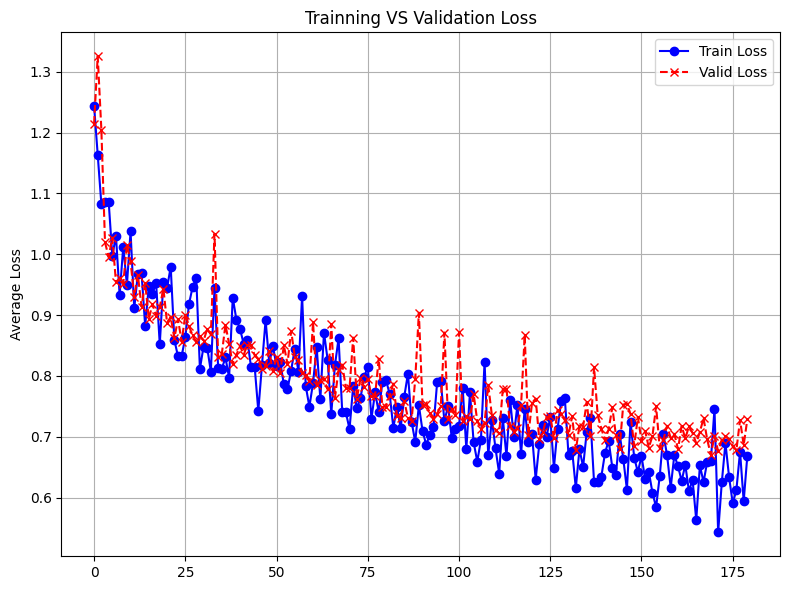

Average test loss: 0.720 | accuracy: 0.740
Confusion Matrix: 
[[  15   27   21    0    3   30    0]
 [   7   68   10    1    8   66    2]
 [   9   11   85    0   15  193    0]
 [   1   18    4    0    1   10    0]
 [   6    3   17    0   94  229    1]
 [   1   10   24    0   35 1940    4]
 [   2    7    0    0    1    4   22]]


In [8]:
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
# print(device)
m, n = 50, 62

transform = transforms.Compose([
   transforms.Resize((m, n), antialias=True),
   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = MLProject2Dataset(data_dir, transform=transform)

torch.manual_seed(42)

train_size = int(0.6 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])
# train_dataset, valid_dataset, test_dataset = split_lesion(dataset, train_size, valid_size, test_size)

BATCH_SIZE = 64
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

net = SimpleModel().to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)

# Summary of our model
# summary(net, (3, m, n))

train_net(net, trainloader, valloader, epochs=20, optimizer=optimizer, loss=loss, device=device)
test_net(net, testloader, loss, device)

## RERUN SIMPLE CNN

[Epoch: 0, batch:     9] Average train loss: 1.468 | accuracy: 0.592
Average val loss: 1.108 | accuracy: 0.661
[Epoch: 0, batch:    19] Average train loss: 1.098 | accuracy: 0.675
Average val loss: 1.125 | accuracy: 0.661
[Epoch: 0, batch:    29] Average train loss: 1.189 | accuracy: 0.658
Average val loss: 1.086 | accuracy: 0.661
[Epoch: 0, batch:    39] Average train loss: 1.058 | accuracy: 0.673
Average val loss: 1.048 | accuracy: 0.661
[Epoch: 0, batch:    49] Average train loss: 0.981 | accuracy: 0.689
Average val loss: 1.060 | accuracy: 0.662
[Epoch: 0, batch:    59] Average train loss: 0.955 | accuracy: 0.683
Average val loss: 1.027 | accuracy: 0.659
[Epoch: 0, batch:    69] Average train loss: 0.945 | accuracy: 0.684
Average val loss: 1.047 | accuracy: 0.661
[Epoch: 0, batch:    79] Average train loss: 0.948 | accuracy: 0.695
Average val loss: 1.135 | accuracy: 0.661
[Epoch: 0, batch:    89] Average train loss: 0.994 | accuracy: 0.664
Average val loss: 1.004 | accuracy: 0.663
[

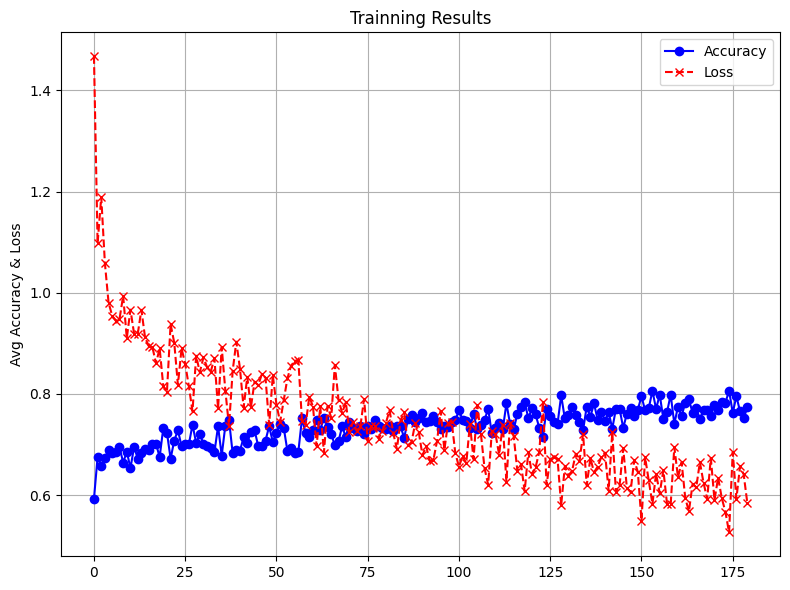

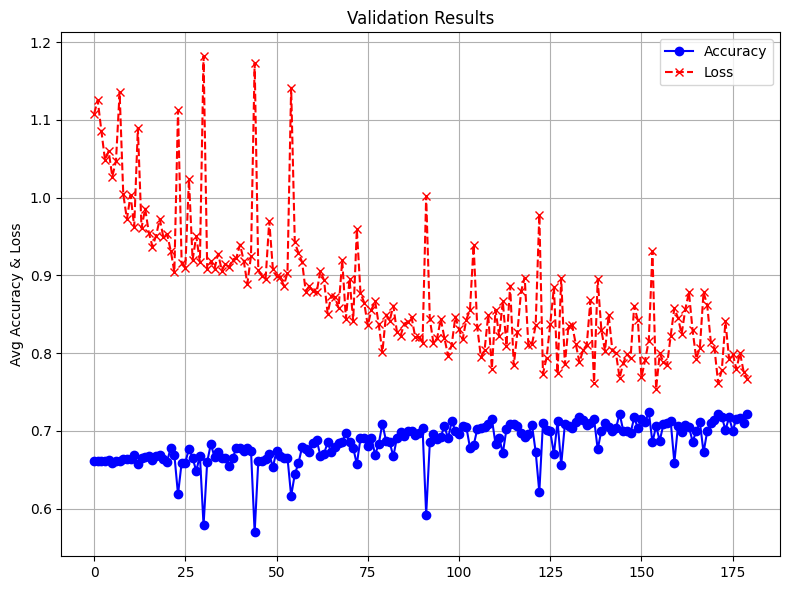

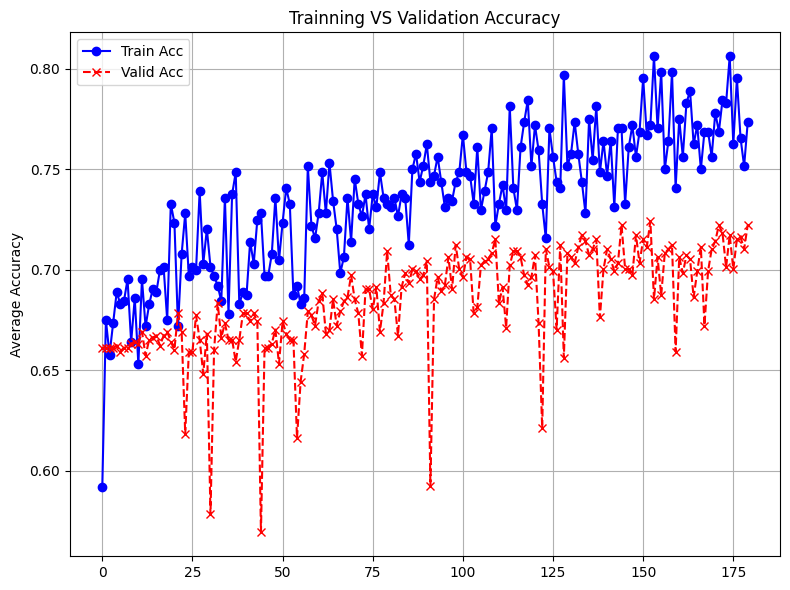

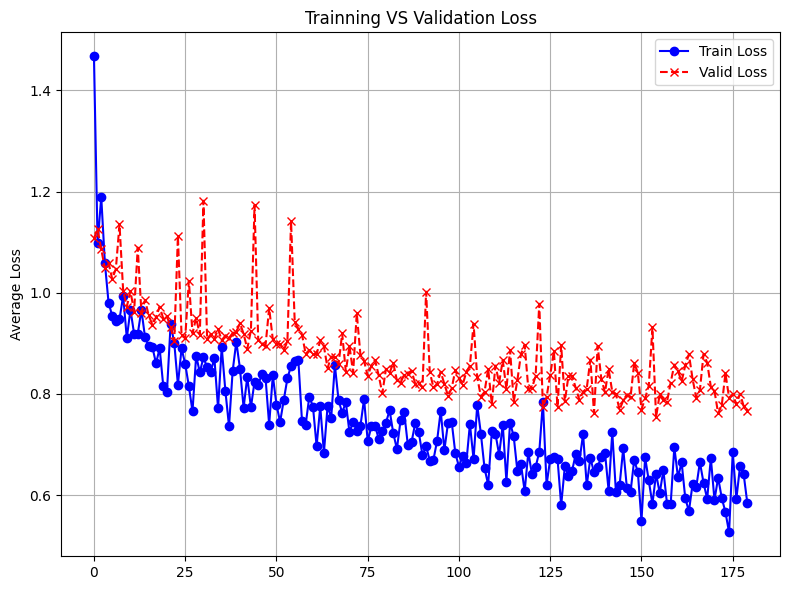

Average test loss: 0.785 | accuracy: 0.703
Confusion Matrix: 
[[   9   36   47    0    1   16    0]
 [   3   99   29    0    7   32    2]
 [   4   15  154    0   14  111    1]
 [   1   20   13    0    2    9    0]
 [   3    5   57    0   80  200    3]
 [   5   33  147    0   41 1744   12]
 [   0    9    1    0    4    8   28]]


In [9]:
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
# print(device)
m, n = 50, 62

transform = transforms.Compose([
   transforms.Resize((m, n), antialias=True),
   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = MLProject2Dataset(data_dir, transform=transform)

torch.manual_seed(42)

train_size = int(0.6 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

# train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])
train_dataset, valid_dataset, test_dataset = split_lesion(dataset, train_size, valid_size, test_size)

BATCH_SIZE = 64
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

net = SimpleModel().to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)

# Summary of our model
# summary(net, (3, m, n))

train_net(net, trainloader, valloader, epochs=20, optimizer=optimizer, loss=loss, device=device)
test_net(net, testloader, loss, device)

## 5ο Ερώτημα - Σύνθετο ΣΝΔ

In [ ]:
class ComplexModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, (3, 3))
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, (3, 3))
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, (3, 3))
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, (3, 3))
        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 512, (3, 3))
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d((2, 2))
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 7)

    def forward(self, x):
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        x = self.pool(self.bn5(F.relu(self.conv5(x))))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.fc(x)
        return x


device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")


transform = transforms.Compose([
   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = MLProject2Dataset(data_dir, transform=transform)

torch.manual_seed(42)

train_size = int(0.6 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

BATCH_SIZE = 64
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

net = ComplexModel().to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

train_net(net, trainloader, valloader, epochs=20, optimizer=optimizer, loss=loss, device=device)
test_net(net, testloader, loss, device)


## 6ο Ερώτημα - Μεταφορά Μάθησης

[Epoch: 0, batch:     9] Average train loss: 1.322 | accuracy: 0.627
Average val loss: 1.240 | accuracy: 0.669
[Epoch: 0, batch:    19] Average train loss: 1.059 | accuracy: 0.666
Average val loss: 0.970 | accuracy: 0.675
[Epoch: 0, batch:    29] Average train loss: 0.993 | accuracy: 0.652
Average val loss: 0.936 | accuracy: 0.686
[Epoch: 0, batch:    39] Average train loss: 0.900 | accuracy: 0.666
Average val loss: 0.852 | accuracy: 0.712
[Epoch: 0, batch:    49] Average train loss: 0.828 | accuracy: 0.727
Average val loss: 0.829 | accuracy: 0.710
[Epoch: 0, batch:    59] Average train loss: 0.776 | accuracy: 0.722
Average val loss: 0.799 | accuracy: 0.720
[Epoch: 0, batch:    69] Average train loss: 0.717 | accuracy: 0.745
Average val loss: 0.790 | accuracy: 0.724
[Epoch: 0, batch:    79] Average train loss: 0.742 | accuracy: 0.720
Average val loss: 0.755 | accuracy: 0.733
[Epoch: 0, batch:    89] Average train loss: 0.700 | accuracy: 0.766
Average val loss: 0.739 | accuracy: 0.741
[

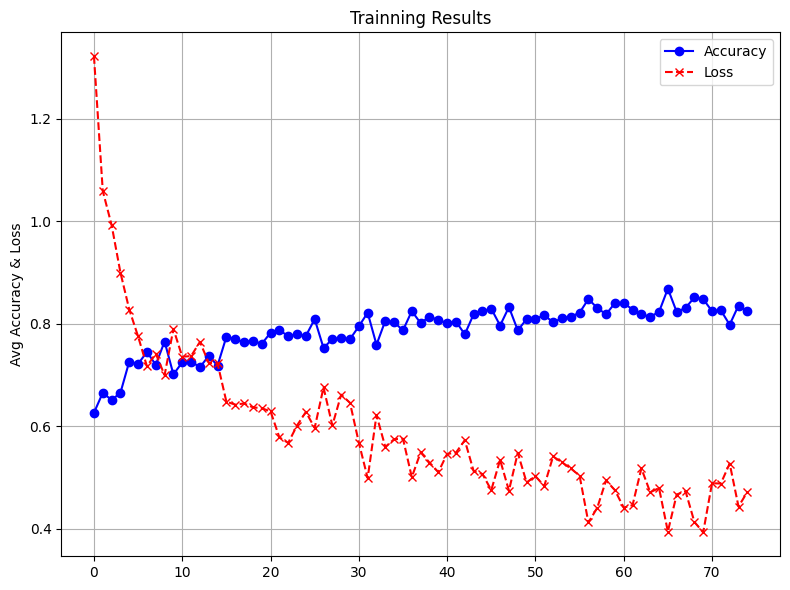

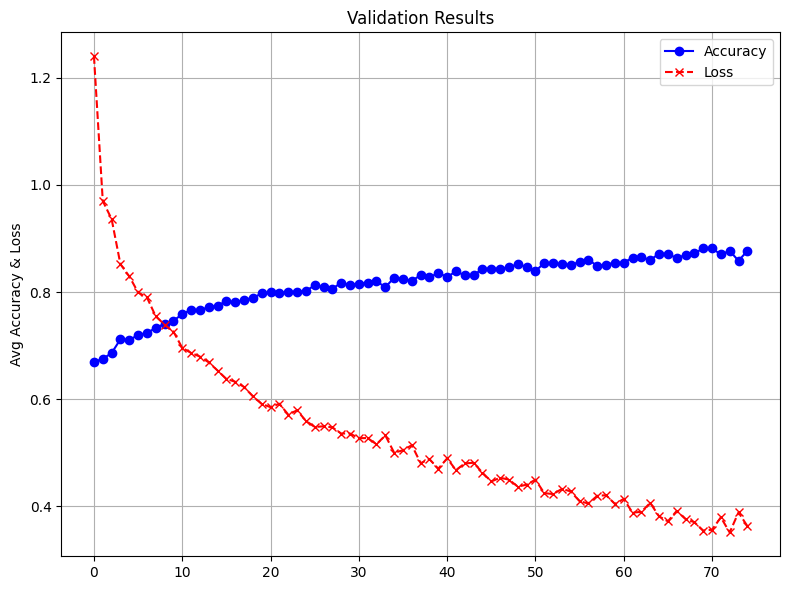

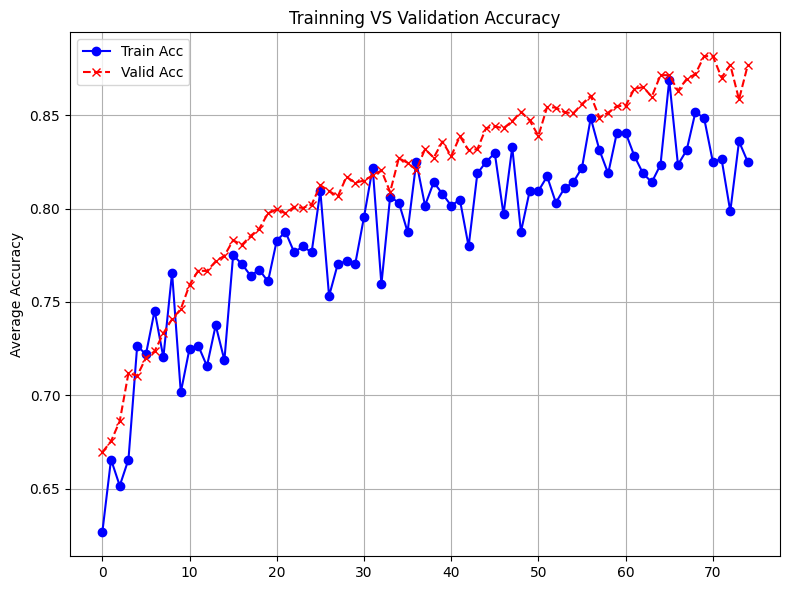

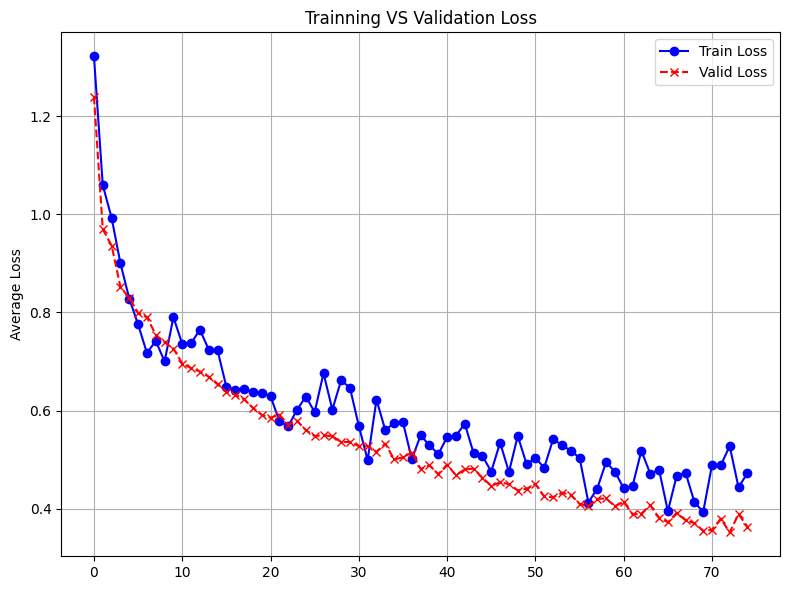

In [22]:
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")

# print(device)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, antialias=True),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256, antialias=True),
        transforms.CenterCrop(224),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_dataset = MLProject2Dataset(data_dir, transform=data_transforms['train'])
valid_dataset = MLProject2Dataset(data_dir, transform=data_transforms['val'])

BATCH_SIZE = 64
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

net = models.resnet34(weights='DEFAULT').to(device)
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 7).to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train_net(net, trainloader, valloader, epochs=5, optimizer=optimizer, loss=loss, device=device)

## 7ο Ερώτημα - Αξιοποίηση Δημογραφικών Δεδομένων

https://stackoverflow.com/questions/51700729/how-to-construct-a-network-with-two-inputs-in-pytorch

In [7]:
class BonusMLProject2Dataset(MLProject2Dataset):
    def __init__(self, data_dir: str, metadata_fname: str ='metadata.csv', transform: transforms = None) -> None:
        super().__init__(data_dir, metadata_fname, transform)
        self.df['age'] = self.df['age'] / 100
        self.df['age'].fillna(self.df['age'].mean(), inplace=True)
        columns_to_encode = ['sex', 'localization']
        one_hot = pd.get_dummies(self.df[columns_to_encode])
        self.df = pd.concat([self.df, one_hot], axis=1)
        self.df.drop(columns_to_encode, axis=1, inplace=True)

    def __getitem__(self, idx):
        path = self.df.iloc[idx, 1] # paths
        img = read_image(path)
        img = img.to(torch.float32) / 255

        if self.transform:
            img = self.transform(img)
        p = pd.Series(self.df.iloc[idx, 5:]).values.astype(np.float64)
        p = torch.from_numpy(p).float()
        return img, p, torch.tensor(self.df.iloc[idx, 3], dtype=torch.int64)


In [8]:
def train_net_bonus(model: nn.Module, trainloader: DataLoader, valloader: DataLoader = None, epochs: int = 10, optimizer: optim = None, loss: nn.modules.loss = None, device: str = 'cpu', print_period: int = 10) -> None:
    model.train()
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for batch, (X, p, y) in enumerate(trainloader, 0):
            X = X.to(device)
            p = p.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            pred = model(X, p)
            current_loss = loss(pred, y)
            current_loss.backward()
            optimizer.step()
            running_loss += current_loss.item()

            yhat = torch.argmax(pred, 1)
            total += y.size(0)
            correct += (yhat == y).type(torch.float).sum().item()   # counts accuracy.

            if batch % print_period == print_period-1:
                avg_loss = running_loss / print_period
                avg_acc = correct / total
                train_acc.append(avg_acc)
                train_loss.append(avg_loss)
                print(f'[Epoch: {epoch}, batch: {batch:5d}] Average train loss: {avg_loss:.3f} | accuracy: {avg_acc:.3f}')
                running_loss = 0.0
                correct = 0
                total = 0

                if valloader is not None:
                    model.eval()  # evaluation mode
                    running_val_loss = 0.0
                    correct_val = 0
                    total_val = 0
                    with torch.no_grad():
                        for batch, (X, p, y) in enumerate(valloader, 0):
                            X, y = X.to(device), y.to(device)
                            p = p.to(device)
                            pred = model(X, p)
                            current_loss = loss(pred, y)
                            running_val_loss += current_loss.item()

                            yhat = torch.argmax(pred, 1)
                            total_val += y.size(0)
                            correct_val += (yhat == y).type(torch.float).sum().item()   # counts accuracy.

                        avg_loss = running_val_loss / len(valloader)
                        avg_acc = correct_val / total_val
                        val_loss.append(avg_loss)
                        val_acc.append(avg_acc)
                        print(f'Average val loss: {avg_loss:.3f} | accuracy: {avg_acc:.3f}')
                    model.train()  # training mode
    plot_acc_loss(train_acc, train_loss, title="Trainning Results")
    if len(val_loss) != 0 and len(val_acc) != 0:
        plot_acc_loss(val_acc, val_loss, title="Validation Results")
        plot_acc_loss(train_acc, val_acc, label1="Train Acc", label2="Valid Acc", y_label="Average Accuracy", title="Trainning VS Validation Accuracy")
        plot_acc_loss(train_loss, val_loss, label1="Train Loss", label2="Valid Loss", y_label="Average Loss", title="Trainning VS Validation Loss")


def test_net_bonus(model: nn.Module, testloader: DataLoader, loss: nn.modules.loss = None, device: str = 'cpu') -> None:
    model.eval()
    total = 0
    correct = 0
    running_loss = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for (X, p, y) in testloader:
            X, y = X.to(device), y.to(device)
            p = p.to(device)
            pred = model(X, p)
            current_loss = loss(pred, y)
            running_loss += current_loss.item()
            yhat = torch.argmax(pred, 1)
            total += y.size(0)
            correct += (yhat == y).type(torch.float).sum().item()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(yhat.cpu().numpy())
    avg_loss = running_loss / len(testloader)
    avg_acc = correct / total
    print("===============")
    print(f"Average test loss: {avg_loss:.3f} | accuracy: {avg_acc:.3f}")
    print("Confusion Matrix: ")
    print(confusion_matrix(y_true, y_pred))
    print("===============")

[Epoch: 0, batch:     9] Average train loss: 1.554 | accuracy: 0.605
Average val loss: 1.277 | accuracy: 0.658
[Epoch: 0, batch:    19] Average train loss: 1.930 | accuracy: 0.672
Average val loss: 1.236 | accuracy: 0.631
[Epoch: 0, batch:    29] Average train loss: 1.826 | accuracy: 0.670
Average val loss: 1.138 | accuracy: 0.659
[Epoch: 0, batch:    39] Average train loss: 1.793 | accuracy: 0.664
Average val loss: 1.082 | accuracy: 0.673
[Epoch: 0, batch:    49] Average train loss: 1.801 | accuracy: 0.648
Average val loss: 1.110 | accuracy: 0.648
[Epoch: 0, batch:    59] Average train loss: 1.699 | accuracy: 0.660
Average val loss: 1.092 | accuracy: 0.642
[Epoch: 0, batch:    69] Average train loss: 1.732 | accuracy: 0.649
Average val loss: 1.071 | accuracy: 0.642
[Epoch: 0, batch:    79] Average train loss: 1.632 | accuracy: 0.674
Average val loss: 1.041 | accuracy: 0.647
[Epoch: 0, batch:    89] Average train loss: 1.608 | accuracy: 0.662
Average val loss: 0.980 | accuracy: 0.666
[

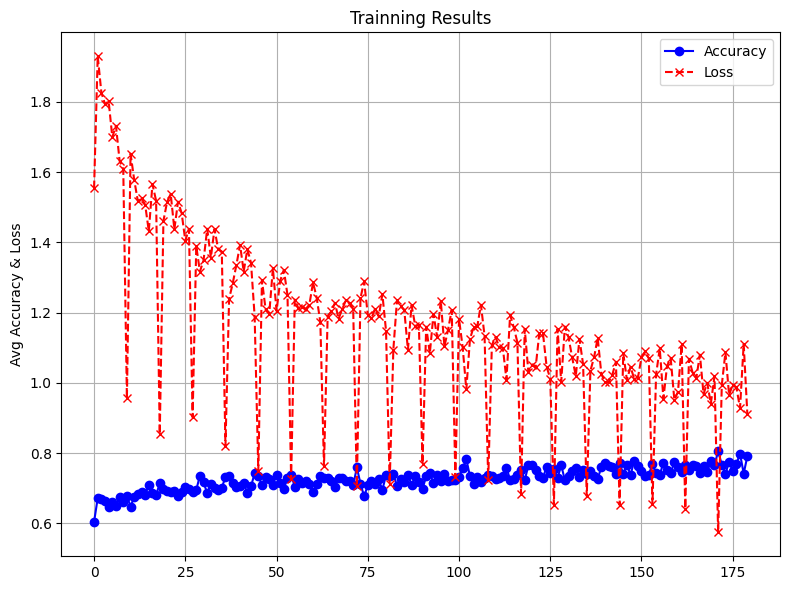

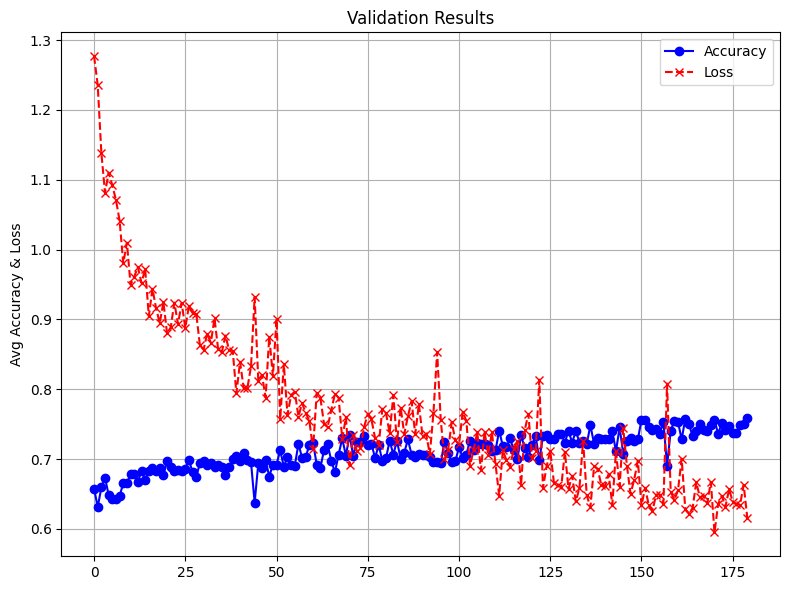

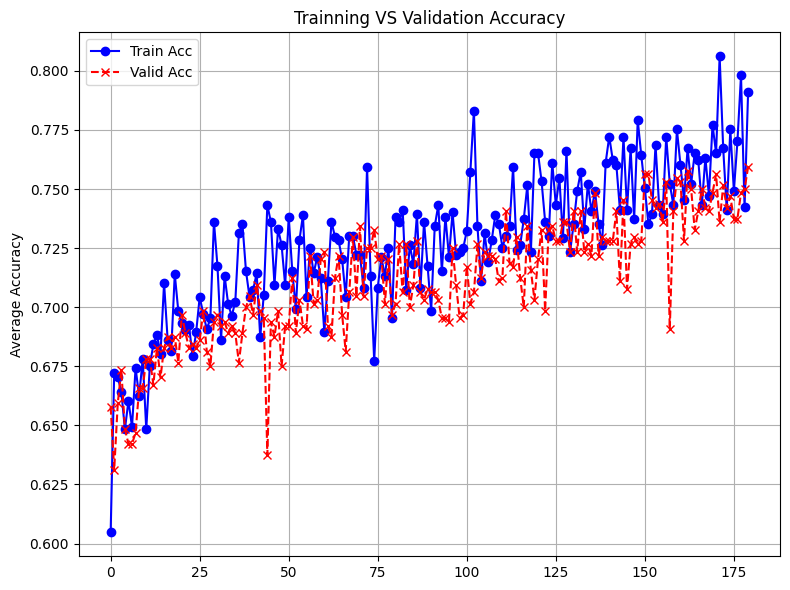

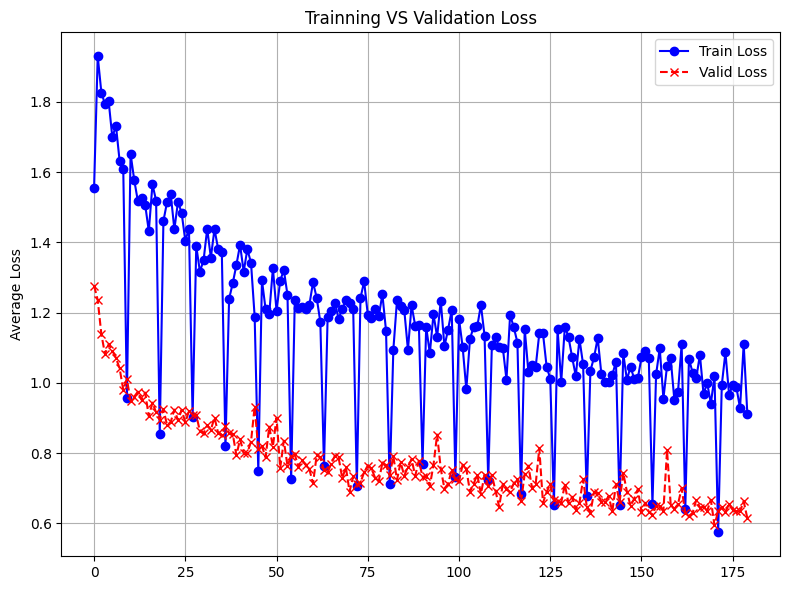

Average test loss: 0.661 | accuracy: 0.760
Confusion Matrix: 
[[  24   34   25    0    1    3    0]
 [  11   99   14    1    2    9    3]
 [   8   52  184    0    9   71    0]
 [   6   14    3    4    0   12    0]
 [  12   19   73    0   79  149    3]
 [  12   39   77    1   25 1877    8]
 [   0   11    1    2    1    9   18]]


In [9]:
class BonusModel(nn.Module):
    def __init__(self):
        device = ("cuda" if torch.cuda.is_available()
            else "mps" if torch.backends.mps.is_available()
            else "cpu")
        super().__init__()
        self.simple_cnn = SimpleModel()
        self.fc = nn.Linear(19, 128)
        self.fc2 = nn.Linear(135, 7).to(device)

    def forward(self, X, p):
        c = self.simple_cnn(X)
        f = F.relu(self.fc(p))
        x = torch.cat((c.view(c.size(0), -1), f.view(f.size(0), -1)), dim=1)
        x = self.fc2(x)
        return x

device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")

m, n = 50, 62

transform = transforms.Compose([
   transforms.Resize((m, n), antialias=True),
   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = BonusMLProject2Dataset(data_dir, transform=transform)

torch.manual_seed(42)

train_size = int(0.6 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

BATCH_SIZE = 64
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

net = BonusModel().to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)

# Summary of our model
# summary(net, (3, m, n))

train_net_bonus(net, trainloader, valloader, epochs=20, optimizer=optimizer, loss=loss, device=device)
test_net_bonus(net, testloader, loss, device)